In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import prince

In [2]:
df = pd.read_csv("Depression Student Dataset.csv")
print(df)

     Gender  Age  Academic Pressure  Study Satisfaction     Sleep Duration  \
0      Male   28                2.0                 4.0          7-8 hours   
1      Male   28                4.0                 5.0          5-6 hours   
2      Male   25                1.0                 3.0          5-6 hours   
3      Male   23                1.0                 4.0  More than 8 hours   
4    Female   31                1.0                 5.0  More than 8 hours   
..      ...  ...                ...                 ...                ...   
497    Male   26                5.0                 2.0  More than 8 hours   
498    Male   24                2.0                 1.0  Less than 5 hours   
499  Female   23                3.0                 5.0          5-6 hours   
500    Male   33                4.0                 4.0  More than 8 hours   
501    Male   18                5.0                 3.0  More than 8 hours   

    Dietary Habits Have you ever had suicidal thoughts ?  Study

In [3]:
def get_contingency_table(dataframe, index_column1, index_column2):
    return pd.crosstab(dataframe[dataframe.columns[index_column1]], dataframe[dataframe.columns[index_column2]])

print(get_contingency_table(df, 2, 3))

Study Satisfaction  1.0  2.0  3.0  4.0  5.0
Academic Pressure                          
1.0                  18   17   25   22   17
2.0                   9   12   19   23   25
3.0                  19   26   22   36   22
4.0                  16   19   23   17   17
5.0                  24   26   14   18   16


In [4]:
print(get_contingency_table(df, 3, 4))

Sleep Duration      5-6 hours  7-8 hours  Less than 5 hours  More than 8 hours
Study Satisfaction                                                            
1.0                        19         20                 23                 24
2.0                        25         25                 25                 25
3.0                        25         33                 19                 26
4.0                        29         31                 29                 27
5.0                        25         19                 27                 26


In [5]:
def make_plot(dataframe, index_column1, index_column2, select_depressive):

    if select_depressive == 0:
        filtered_df = dataframe[dataframe[dataframe.columns[-1]] != "Yes"]
    elif select_depressive == 1:
        filtered_df = dataframe[dataframe[dataframe.columns[-1]] != "No"]
    else:
        filtered_df = dataframe
    
    cont_table = get_contingency_table(filtered_df, index_column1, index_column2)
    print(cont_table)

    ca = prince.CA(n_components=2)
    ca = ca.fit(cont_table)
    
    # Extract row and column coordinates
    row_coords = ca.row_coordinates(cont_table)
    col_coords = ca.column_coordinates(cont_table)

    marker = "."
    
    # Plotting the results
    plt.figure(figsize=(8, 8))
    plt.scatter(row_coords[0], row_coords[1], c='red', label=f"{cont_table.T.columns.name} (Rows)", marker=marker)
    plt.scatter(col_coords[0], col_coords[1], c='blue', label=f'{cont_table.columns.name} (Columns)', marker=marker)

    r = max(row_coords.abs().max().max(), col_coords.abs().max().max()) + .005
    
    # Adding labels
    for i, txt in enumerate(cont_table.index):
        plt.annotate(txt, (row_coords[0][txt], row_coords[1][txt]), color='red')
    
    for i, txt in enumerate(cont_table.columns):
        plt.annotate(txt, (col_coords[0][txt], col_coords[1][txt]), color='blue')
    
    plt.title('Correspondence Analysis')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.xlim([-r, r])
    plt.ylim([-r, r])
    plt.plot([-r, r], [0, 0], color="black")
    plt.plot([0, 0], [-r, r], color="black")
    plt.legend()
    plt.grid()
    plt.show()

Sleep Duration      5-6 hours  7-8 hours  Less than 5 hours  More than 8 hours
Study Satisfaction                                                            
1.0                         4          7                  6                  6
2.0                         6          9                 10                 13
3.0                        11         15                 11                 15
4.0                        17         20                 14                 19
5.0                        21         10                 18                 18


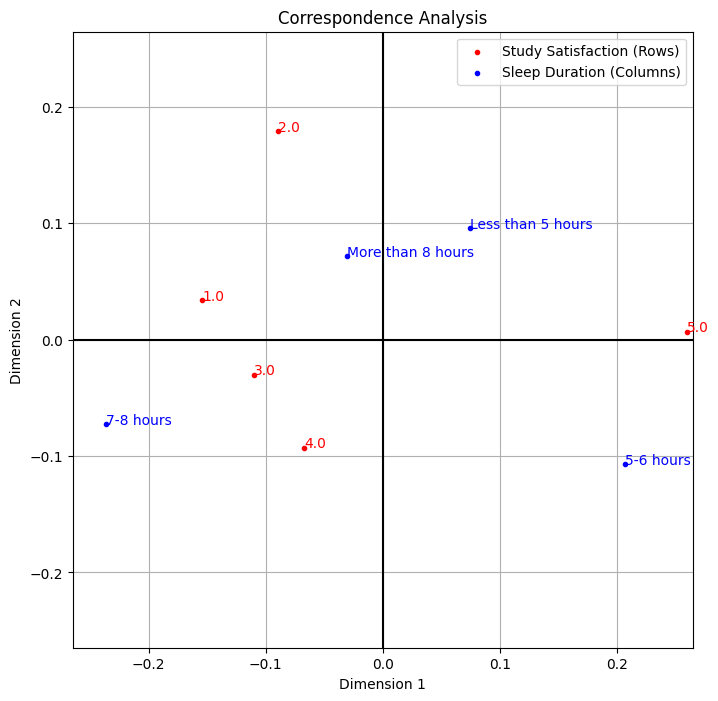

Sleep Duration      5-6 hours  7-8 hours  Less than 5 hours  More than 8 hours
Study Satisfaction                                                            
1.0                        15         13                 17                 18
2.0                        19         16                 15                 12
3.0                        14         18                  8                 11
4.0                        12         11                 15                  8
5.0                         4          9                  9                  8


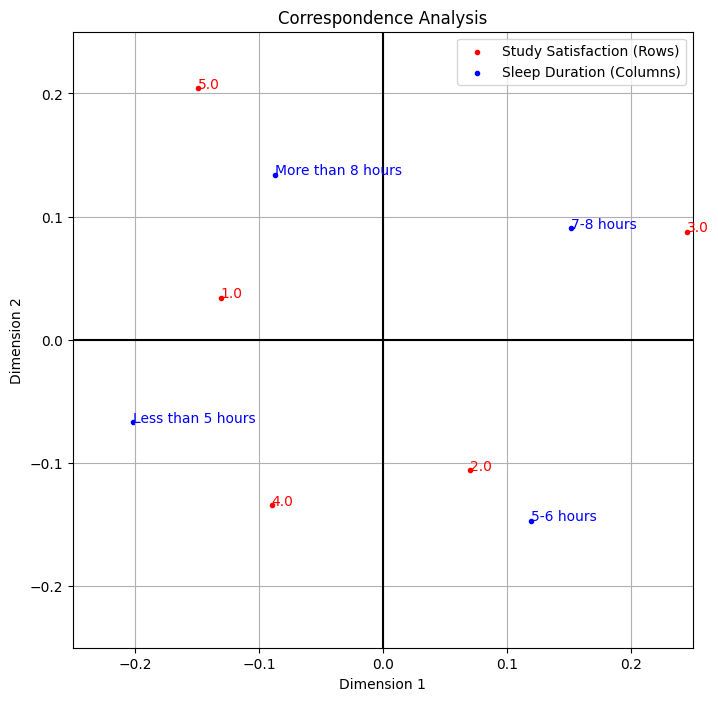

Sleep Duration      5-6 hours  7-8 hours  Less than 5 hours  More than 8 hours
Study Satisfaction                                                            
1.0                        19         20                 23                 24
2.0                        25         25                 25                 25
3.0                        25         33                 19                 26
4.0                        29         31                 29                 27
5.0                        25         19                 27                 26


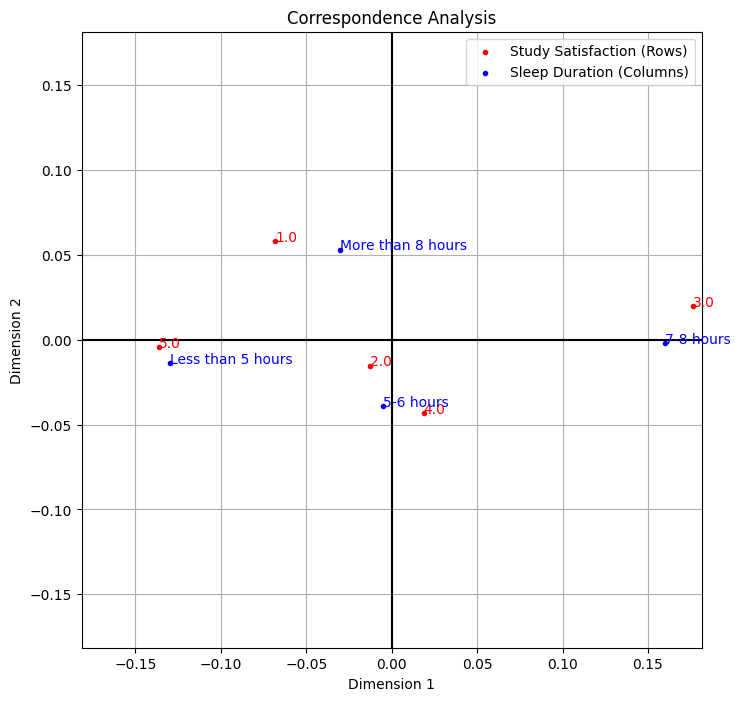

In [6]:
index_column1, index_column2 = 3, 4

#print(get_contingency_table(df, index_column1, index_column2))
make_plot(df, index_column1, index_column2, 0) # Que les non depressifs
make_plot(df, index_column1, index_column2, 1) # Que les depressifs
make_plot(df, index_column1, index_column2, -1) # Tout le monde